In [1]:
import torch
import os
from torch.utils.data import DataLoader
from utils.utils import safe_load_mesh
from models.vae_models import VAE, VAE2, KL_divergence
from models.discriminators import PointNet2
from models.ghd_reconstruct import GHD_Reconstruct
from torch_geometric.data import Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.utils import save_models, load_models, plot_wandb
from sklearn.decomposition import PCA
import numpy as np
from pytorch3d.loss import mesh_laplacian_smoothing, mesh_normal_consistency
from ghd.losses.mesh_loss import Rigid_Loss
from models.vae_datasets import GHDDataset as Dataset
from visualization.gallery import get_fig, get_fig_advanced
from IPython.display import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# data conf
root = ''
ghd_chk_root = os.path.join(root, 'checkpoints/ghd_fitting')
ghd_run = 'vanilla'
ghd_chk_name = 'ghb_fitting_checkpoint_5.pkl'
alignment_root = os.path.join(root, 'checkpoints/alignment')
canonical_name = 'canonical_typeB'
canonical_Meshes = safe_load_mesh(os.path.join(alignment_root, canonical_name, 'part_aligned_updated.obj'))
cases = [case for case in os.listdir(ghd_chk_root) if os.path.isdir(os.path.join(ghd_chk_root, case)) and case != canonical_name]
eigen_chk = os.path.join(root, alignment_root, canonical_name, "canonical_typeB_144.pkl")

# model conf
hidden_dim = 256
latent_dim = 108
batch_size = 128
device = torch.device('cuda:0')
use_norm = True
use_reg = True
rigidloss = Rigid_Loss(canonical_Meshes.to(device))
reload_epoch = 10000

# meta
meta = 'vanilla'
withscale = False
log_path = os.path.join("./checkpoints/first_stage_unconditional", meta)
get_gif = True
save_objs = False

/home/wenhao/anaconda3/envs/gnn2/lib/python3.8/site-packages/pytorch3d/ops/laplacian_matrices.py:130: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:605.)
  L = torch.sparse.FloatTensor(idx, cot.view(-1), (V, V))


In [3]:
from models.mesh_plugins import MeshPlugins, MeshRegulizer
import pyvista as pv
pv.set_jupyter_backend('html')
pv.start_xvfb()

cep_chk = os.path.join(alignment_root, canonical_name, "diff_centreline_checkpoint.pkl")
trimmed_mesh_path = os.path.join(os.getcwd(), alignment_root, canonical_name, "part_trimmed_short.obj")
wave_based_trimming = False
mesh_plugin = MeshPlugins(canonical_Meshes, cep_chk, 
                          max_loops=[15, 13, 12], loop_start=[11, 9, 8], 
                          trimmed_mesh_path=trimmed_mesh_path, wave_based_trimming=wave_based_trimming)
# set visualize=True to monitor calibration
mesh_regulizer = MeshRegulizer(mesh_plugin, device=device, visualize=False)

Skeletonizing: 100%|██████████| 4143/4143 [00:00<00:00, 237494.55it/s]
/home/wenhao/anaconda3/envs/gnn2/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/media/yaplab/"HDD Storage"/wenhao/AneuG/models/mesh_plugins.py:683: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cap_tensor = torch.tensor(cap_indices, device=faces.device)


In [4]:
# dataset
ghd_reconstruct = GHD_Reconstruct(canonical_Meshes, eigen_chk, num_Basis=12**2, device=device)
dataset = Dataset(ghd_chk_root, ghd_run, ghd_chk_name, ghd_reconstruct, cases, withscale=withscale, normalize=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
mean, std = dataset.get_mean_std()

# model
generator = VAE(dataset.get_dim(), hidden_dim, latent_dim, withscale=withscale).to(device)
discriminator = PointNet2(use_norm=use_norm).to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=2000, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=2000, gamma=0.5)

# reload
generator, optimizer_G, epoch_ = load_models(generator, optimizer_G, log_path, reload_epoch)
generator.eval()

116 cases out of 116 have GHD checkpoint
Learning rate in optimizer_G: 9.765625e-07


VAE(
  (fc1): Linear(in_features=432, out_features=256, bias=True)
  (res1): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc21): Linear(in_features=256, out_features=108, bias=True)
  (fc22): Linear(in_features=256, out_features=108, bias=True)
  (fc3): Linear(in_features=108, out_features=256, bias=True)
  (res2): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [5]:
"""mesh render"""
from visualization.mesh_renders import MeshRender

out_dir = "./render/gifs"
mesh_render = MeshRender(out_dir=out_dir, device=device)
mesh_render.init_mesh_render(image_size=1024, dist=1, elev=45, azim=90)

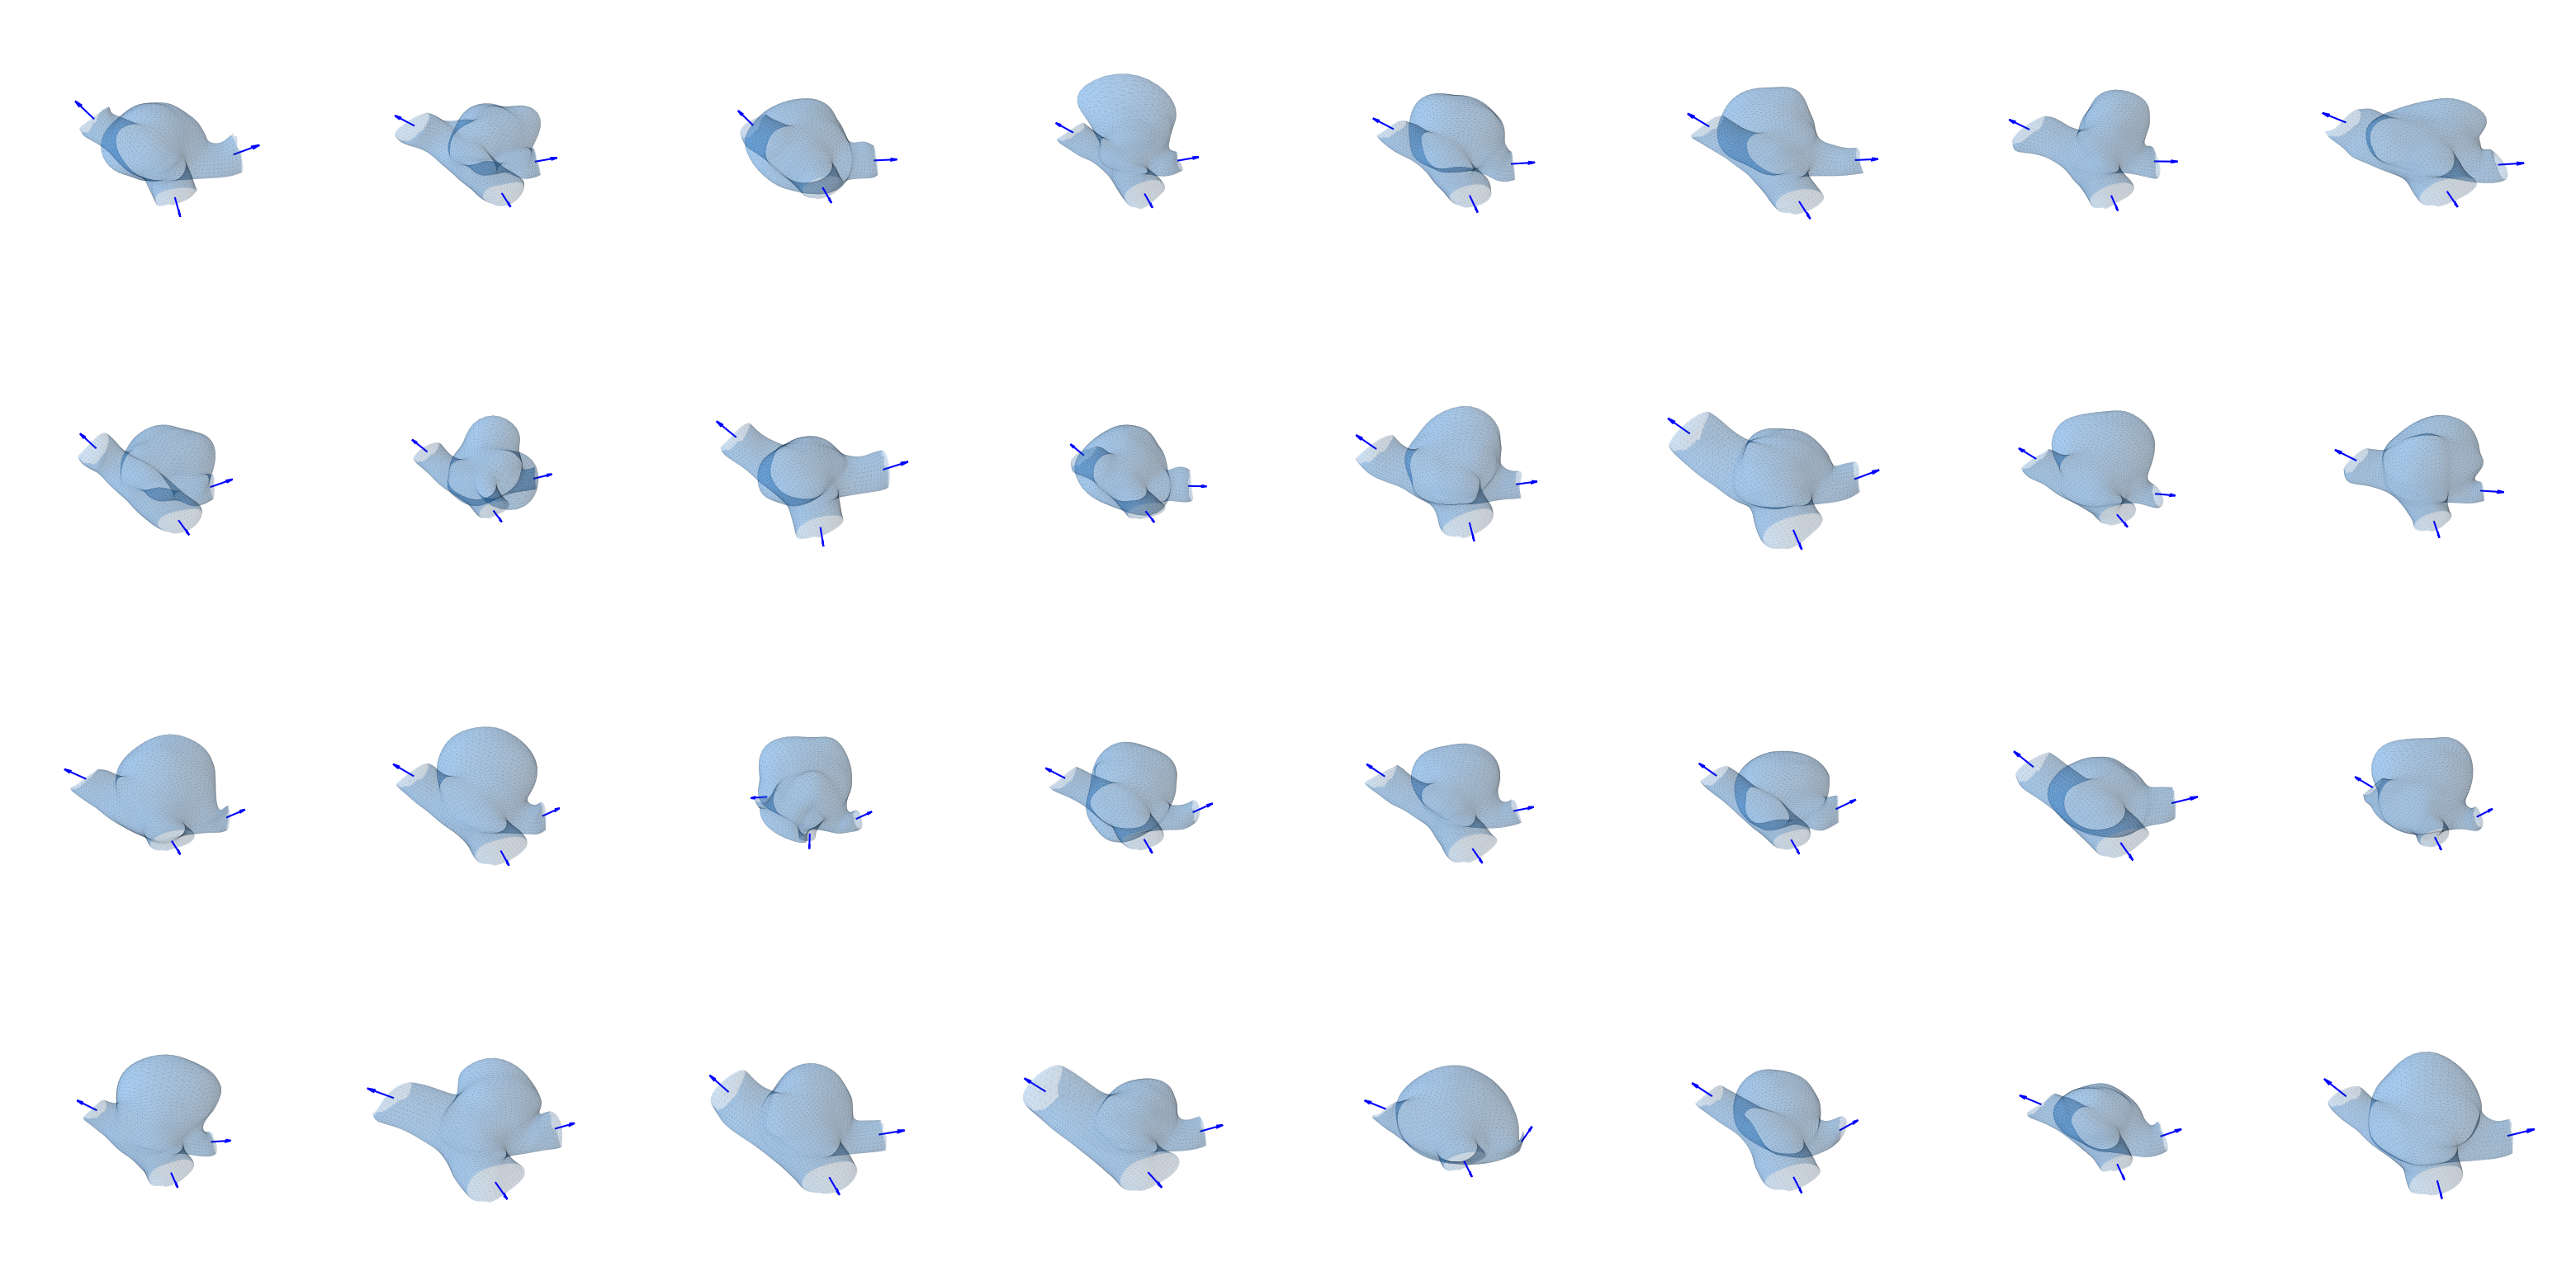

In [6]:
# uncomment the following line to enable interactive plot
# %matplotlib widget

# unconditional generation
label='unconditional_generation'
B = 32
z = torch.randn(B, latent_dim).to(device) * 1.0
if withscale:
    ghd_fake, scale_fake = generator.decode(z, False)
    scale_fake = dataset.denorm_scale(scale_fake)
else:
    ghd_fake = generator.decode(z, True)
    scale_fake = None
data_fake = ghd_reconstruct.forward(ghd_fake, mean, std, use_norm)
fig = get_fig_advanced(ghd_reconstruct, data_fake, 8, Title=None, mesh_plugin=mesh_plugin, plot_tangent=True, scale=scale_fake)
save_path = "render/images/unconditional/{}/{}.png".format(label, meta)
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show(fig)

# create gifs
meshes = ghd_reconstruct.ghd_forward_as_Meshes(ghd_fake * std.to(device) + mean.to(device), denormalize_shape=False, trimmed_faces=mesh_plugin.trimmed_faces)

if get_gif:
    # meshes = ghd_reconstruct.ghd_forward_as_Meshes(ghd_fake * std.to(device) + mean.to(device), denormalize_shape=False, trimmed_faces=None)
    out_dir = "render/wepage/unconditional"
    mesh_render.render_rotational_gif(meshes, dual_texture=False, n_row=8, fps=36, out_dir=out_dir, label=label)
try:
    display(Image(filename=f"./render/gifs/{label}.gif"))
    pass
except:
    pass
if save_objs:
    save_dir = "render/meshes/unconditional/{}/{}".format(label, meta)
    os.makedirs(os.path.dirname(save_dir), exist_ok=True)
    mesh_render.save_objs(meshes, label, save_dir=save_dir, add_random_string=False)